**Chapter 2 – End-to-end Machine Learning project**

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

*This notebook contains all the sample code and solutions to the exercices in chapter 2.*

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [270]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get the data

In [271]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [272]:
fetch_housing_data()

In [273]:
import pandas as pd
pd.set_option('display.max_rows', 500)

#def load_housing_data(housing_path=HOUSING_PATH):
#    csv_path = os.path.join(housing_path, "housing.csv")
#    return pd.read_csv(csv_path)

DATASET_PATH = "datasets/uci/"
def load_uci_data(path):
    csv_path = os.path.join(DATASET_PATH, path)
    return pd.read_csv(csv_path)

In [274]:
#housing = load_housing_data()
#housing.head()

#Otros candidatos a agregar:

# Producto 11: Incidencia por region
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto11

# Producto 26: Casos nuevos con sintomas por region
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto26

# Producto 27: Casos nuevos sin sintomas por region
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto27

# Producto 38: Casos fallecidos por comuna (usar CasosFallecidosPorComuna_std)
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto38

# -------------------------------------------------------------------------------

# Producto 8: Pacientes COVID UCI (RM)
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto8
uci_region = load_uci_data("UCI_T.csv")

# Producto 19: Casos activos (RM)
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto19
casos_activos = load_uci_data("ActivosComuna_std.csv") #Nuevo

# Producto 20: Número de ventiladores
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto20
vent_disp = load_uci_data("NumeroVentiladores_T.csv")

# Producto 23: Pacientes críticos
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto23
uci_covid_nacional = load_uci_data("PacientesCriticos_T.csv")

# Producto 24: Camas Hospital Diario
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto24
camas = load_uci_data("CamasHospital_Diario_T.csv")

# Producto 35: Comorbilidad
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto35
comorb_nacional = load_uci_data("Comorbilidad_T.csv")

# Producto 37: Defunciones
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto37
defunc_nacional = load_uci_data("Defunciones_T.csv")

# Producto 44: Evolución semanal de egresos hospitalarios pacientes COVID-19
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto44
egresos_nacional = load_uci_data("Egresos_std.csv") #Nuevo

# Producto 52: Camas Hospital (RM)
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto52
camas_region = load_uci_data("CamasHospital_Regional_std.csv")

## Limpieza de datos

In [275]:
camas_region = camas_region[camas_region["Region"].str.match("Metropolitana")]
camas_region = camas_region.groupby(["Fecha", "Serie"])["Fecha", "Serie", "Casos"].sum().reset_index()
camas_region = camas_region.pivot_table(index=['Fecha'], columns=['Serie'], values='Casos').fillna(0)
#camas_region.set_index(camas_region["Fecha"], inplace=True)
#camas_region.drop(axis=1, labels="Fecha", inplace=True)
camas_region.drop(axis=1, labels="Camas base (2019)", inplace=True)

camas_region.index.name=None

#Tenemos tambien las camas nacionales, pero es preferible usar las regionales
camas.columns = ['Fecha', 'Camas basicas nac.', 'Camas medias nac.', 'Camas UTI nac.', 'Camas UCI nac.']
camas.set_index(camas["Fecha"], drop=True, inplace=True)
camas.drop(axis=1, labels=["Fecha"], inplace=True)
camas.index.name = None

# Pendiente: quitar las primeras, no las segundas. !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
comorb_nacional.drop(comorb_nacional.columns[[*range(12,23)]], axis=1, inplace=True)
comorb_nacional.columns
comorb_nacional.drop([0],axis=0, inplace=True)
comorb_nacional.set_index(comorb_nacional["Comorbilidad"], drop=True, inplace=True)
comorb_nacional.drop(axis=1, labels=["Comorbilidad"], inplace=True)
comorb_nacional.index.name = None

defunc_nacional = defunc_nacional[["Fecha","Defunciones_2020-07-16"]]
defunc_nacional.columns = ["Fecha", "Defunciones nacional"]
defunc_nacional.set_index(defunc_nacional["Fecha"], inplace=True)
defunc_nacional.drop(axis=1, labels="Fecha", inplace=True)
defunc_nacional.index.name = None

vent_disp.columns = ["Fecha", "Total vent.", "Vent. ocupados", "Vent. disponibles"]
vent_disp.set_index(vent_disp["Fecha"], inplace=True)
vent_disp.drop(axis=1, labels="Fecha", inplace=True)
vent_disp.index.name = None

uci_covid_nacional.columns = ["Fecha", "Pac. criticos nacional"]
uci_covid_nacional.set_index(uci_covid_nacional["Fecha"], inplace=True)
uci_covid_nacional.drop(axis=1, labels="Fecha", inplace=True)
uci_covid_nacional.index.name = None

uci_region = uci_region[["Region", "Metropolitana"]]
uci_region.columns = ["Fecha", "Casos diarios region"]
uci_region.drop([0,1],axis=0, inplace=True)
uci_region.set_index(uci_region["Fecha"], inplace=True)
uci_region.drop(axis=1, labels="Fecha", inplace=True)
uci_region.index.name = None

#casos_activos = casos_activos.rename(columns = {'Casos activos':'Casos activos region'})
casos_activos = casos_activos.loc[:,["Region", "Fecha", "Casos activos"]]
casos_activos.columns = ["Region", "Fecha", "Casos activos region"]
casos_activos = casos_activos[casos_activos["Region"].str.match("Metropolitana")]
casos_activos = casos_activos.groupby("Fecha")["Fecha", "Casos activos region"].sum().reset_index()
casos_activos.set_index(casos_activos["Fecha"], inplace=True)
casos_activos.drop(axis=1, labels="Fecha", inplace=True)
casos_activos.index.name=None

# Este requiere tratamiento
#egresos_nacional = egresos_nacional[["Fecha Publicación", "Egresos"]]
#egresos_nacional.set_index(egresos_nacional["Fecha Publicación"],inplace=True)
#egresos_nacional.drop(axis=1, labels="Fecha Publicación", inplace=True)
#egresos_nacional.index.name = None



#camas.set_index(camas["Tipo de cama"], drop=True)
#amas.drop(axis=1, labels=["Tipo de cama"])

#amas.set_index(camas["Tipo de cama"], drop=True)
#amas.drop(axis=1, labels=["Tipo de cama"])

/tmp/ipykernel_53851/560033472.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  camas_region = camas_region.groupby(["Fecha", "Serie"])["Fecha", "Serie", "Casos"].sum().reset_index()
/tmp/ipykernel_53851/560033472.py:51: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  casos_activos = casos_activos.groupby("Fecha")["Fecha", "Casos activos region"].sum().reset_index()


In [276]:
data = pd.merge(camas, comorb_nacional, how='outer',left_index=True, right_index=True)
data = pd.merge(data, camas_region, how='outer', left_index=True, right_index=True)
data = pd.merge(data, defunc_nacional,how='outer',left_index=True, right_index=True)
data = pd.merge(data, vent_disp,how='outer', left_index=True, right_index=True)
data = pd.merge(data, uci_covid_nacional,how='outer', left_index=True, right_index=True)
data = pd.merge(data, uci_region,how='outer', left_index=True, right_index=True)
data = pd.merge(data, casos_activos,how='outer', left_index=True, right_index=True)

data = data.loc['2020-04-14':]
data.index = pd.to_datetime(data.index)
for col in data:
    data[col] = pd.to_numeric(data[col], errors='coerce')

In [277]:
#uci_region
# VER UMBRAL y proporción de NaNs
#data.columns
data_rows = data.shape[0]
nan_proportions = data.apply(lambda x: x.isnull().sum() / data_rows, axis=0).to_frame()
#nan_proportions
data_non_imputable = nan_proportions.loc[nan_proportions[0] >= 0.15]
data_non_imputable
#type(nan_proportions)

#data1.apply(lambda x: x.interpolate())

# Hacer



,0
Hipertensión arterial,0.744921
Diabetes,0.744921
Obesidad,0.744921
Asma,0.744921
Enfermedad cardiovascular,0.744921
Enfermedad pulmonar crónica,0.744921
Cardiopatía crónica,0.744921
Enfermedad renal crónica,0.744921
Enfermedad neurológica crónica,0.744921
Inmunocomprometido,0.744921


In [278]:
def inputData(colname, df):
    colname=colname + " interp"
    df = df.assign(colname=df.interpolate(method='spline', order=3))
    return df

In [279]:
inputable = nan_proportions.loc[nan_proportions[0] <= 0.15]
inputable

,0
Camas basicas nac.,0.004515
Camas medias nac.,0.004515
Camas UTI nac.,0.004515
Camas UCI nac.,0.004515
Camas UCI habilitadas,0.002257
Camas UCI ocupadas COVID-19,0.002257
Camas UCI ocupadas no COVID-19,0.002257
Total vent.,0.000000
Vent. ocupados,0.000000
Vent. disponibles,0.000000


In [280]:
#data = data.assign(Hipertensión_arterial_interp=data["Hipertensión arterial"].interpolate(method='spline', order=3, inplace=True))

#Columnas con <15% casos faltantes
data["Camas basicas nac."].interpolate(method='spline', order=2, inplace=True)
data["Camas medias nac."].interpolate(method='spline', order=2, inplace=True)
data["Camas UTI nac."].interpolate(method='spline', order=2, inplace=True)
data["Camas UCI nac."].interpolate(method='spline', order=2, inplace=True)
data["Camas UCI habilitadas"].interpolate(method='spline', order=2, inplace=True)
data["Camas UCI ocupadas COVID-19"].interpolate(method='spline', order=2, inplace=True)
data["Camas UCI ocupadas no COVID-19"].interpolate(method='spline', order=2, inplace=True)

#Columnas con >15% casos faltantes
data["Pac. criticos nacional"].rolling(24, min_periods=1,).median()
data["Hipertensión arterial"].interpolate(method='linear', inplace=True)
data["Diabetes"].interpolate(method='linear', inplace=True)
data["Obesidad"].interpolate(method='linear', inplace=True)
data["Asma"].interpolate(method='linear', inplace=True)
data["Enfermedad cardiovascular"].interpolate(method='linear', inplace=True)
data["Enfermedad pulmonar crónica"].interpolate(method='linear', inplace=True)
data["Cardiopatía crónica"].interpolate(method='linear', inplace=True)
data["Enfermedad renal crónica"].interpolate(method='linear', inplace=True)
data["Enfermedad neurológica crónica"].interpolate(method='linear', inplace=True)
data["Inmunocomprometido"].interpolate(method='linear', inplace=True)
data["Enfermedad hepática crónica"].interpolate(method='linear', inplace=True)
data["Defunciones nacional"].rolling(24, min_periods=1,).median()
data["Casos activos region"].interpolate(method='spline', order=3, inplace=True)

#data["Pac. criticos nacional"].interpolate(method='time', inplace=True)
#data["Hipertensión arterial"].interpolate(method='time', inplace=True)
#data["Diabetes"].interpolate(method='time', inplace=True)
#data["Obesidad"].interpolate(method='time', inplace=True)
#data["Asma"].interpolate(method='time', inplace=True)
#data["Enfermedad cardiovascular"].interpolate(method='time', inplace=True)
#data["Enfermedad pulmonar crónica"].interpolate(method='time', inplace=True)
#data["Cardiopatía crónica"].interpolate(method='time', inplace=True)
#data["Enfermedad renal crónica"].interpolate(method='time', inplace=True)
#data["Enfermedad neurológica crónica"].interpolate(method='time', inplace=True)
#data["Inmunocomprometido"].interpolate(method='time', inplace=True)
#data["Enfermedad hepática crónica"].interpolate(method='time', inplace=True)
#data["Defunciones nacional"].interpolate(method='time', inplace=True)
#data["Casos activos region"].interpolate(method='time', inplace=True)

#for col in list(inputable.index):
#    print(col)
#    data = inputData(col, data)

In [281]:
data.apply(lambda x: x.isnull().sum() / data_rows, axis=0).to_frame()

,0
Camas basicas nac.,0.004515
Camas medias nac.,0.004515
Camas UTI nac.,0.004515
Camas UCI nac.,0.004515
Hipertensión arterial,0.092551
Diabetes,0.092551
Obesidad,0.092551
Asma,0.092551
Enfermedad cardiovascular,0.092551
Enfermedad pulmonar crónica,0.092551


In [282]:
data.isnull().sum(axis=1)

2020-04-14    16
2020-04-15    15
2020-04-16    11
2020-04-17    11
2020-04-18    11
2020-04-19    11
2020-04-20    11
2020-04-21    11
2020-04-22    11
2020-04-23    11
2020-04-24    11
2020-04-25    11
2020-04-26    11
2020-04-27    11
2020-04-28    11
2020-04-29    11
2020-04-30    11
2020-05-01    11
2020-05-02    11
2020-05-03    11
2020-05-04    11
2020-05-05    11
2020-05-06    11
2020-05-07    11
2020-05-08    11
2020-05-09    11
2020-05-10    11
2020-05-11    11
2020-05-12    11
2020-05-13    11
2020-05-14    11
2020-05-15    11
2020-05-16    11
2020-05-17    11
2020-05-18    11
2020-05-19    11
2020-05-20    11
2020-05-21    11
2020-05-22    11
2020-05-23    11
2020-05-24    11
2020-05-25     0
2020-05-26     0
2020-05-27     0
2020-05-28     0
2020-05-29     0
2020-05-30     0
2020-05-31     0
2020-06-01     0
2020-06-02     0
2020-06-03     0
2020-06-04     0
2020-06-05     0
2020-06-06     0
2020-06-07     0
2020-06-08     0
2020-06-09     0
2020-06-10     0
2020-06-11    

In [283]:
data = data.loc['2020-05-25':]

- No quedan datos NaN en todo el dataframe

## Visualización de los datos

In [284]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [15, 10]

Text(0, 0.5, 'Cantidad camas')

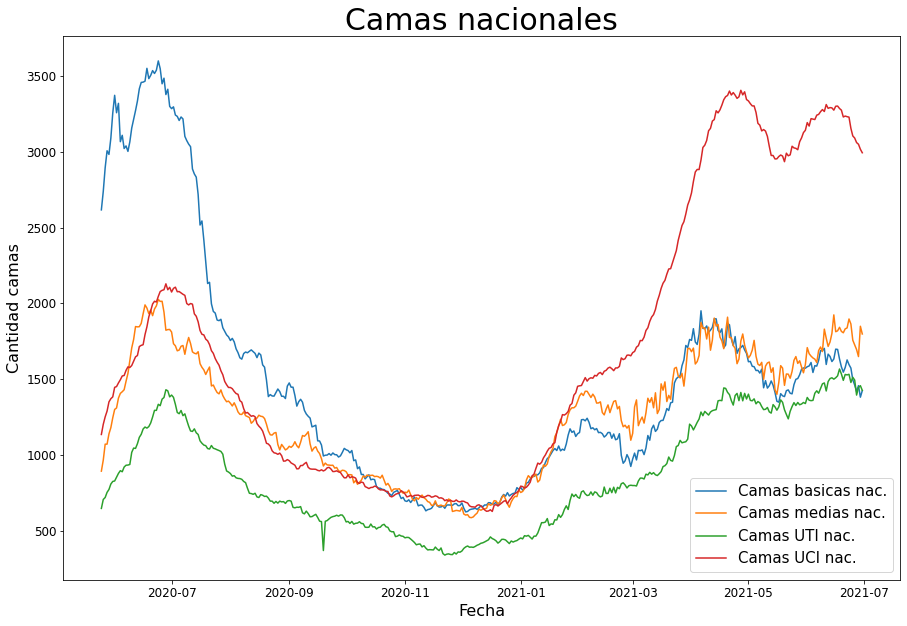

In [285]:
fig, ax1 = plt.subplots(1, 1)
ax1.plot(data.iloc[:,[0,1,2,3]])
ax1.legend(('Camas basicas nac.', 'Camas medias nac.', 'Camas UTI nac.',
       'Camas UCI nac.'), fontsize=15 , loc=4)
plt.title("Camas nacionales", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Cantidad camas", fontsize=16)

Text(0, 0.5, 'Cantidad camas')

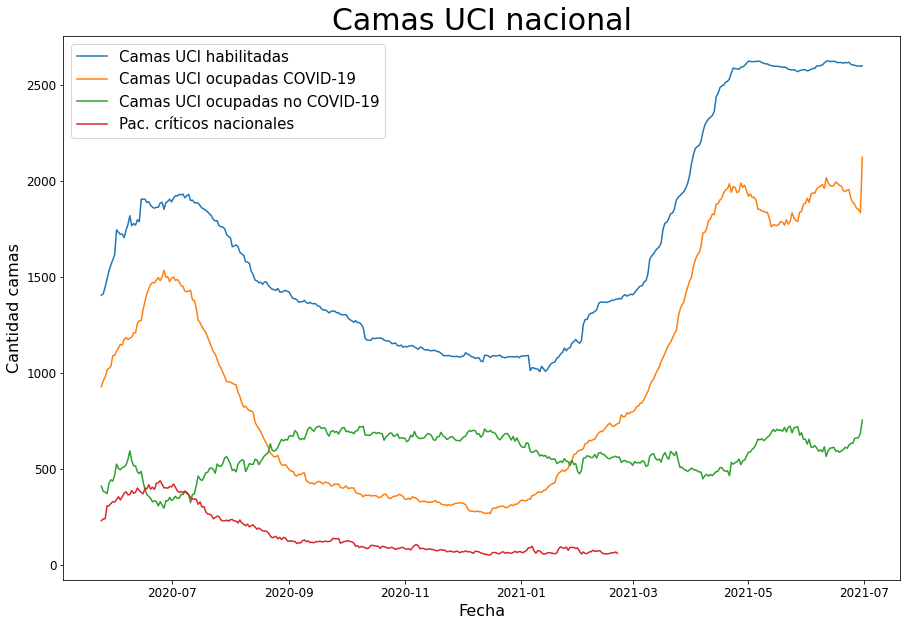

In [286]:
fig, ax2 = plt.subplots(1, 1)
ax2.plot(data.iloc[:,[15,16,17,22]])
ax2.legend(('Camas UCI habilitadas',
       'Camas UCI ocupadas COVID-19', 'Camas UCI ocupadas no COVID-19', 'Pac. críticos nacionales'), fontsize=15)
plt.title("Camas UCI nacional", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Cantidad camas", fontsize=16)

Text(0, 0.5, 'Personas con comorbilidad')

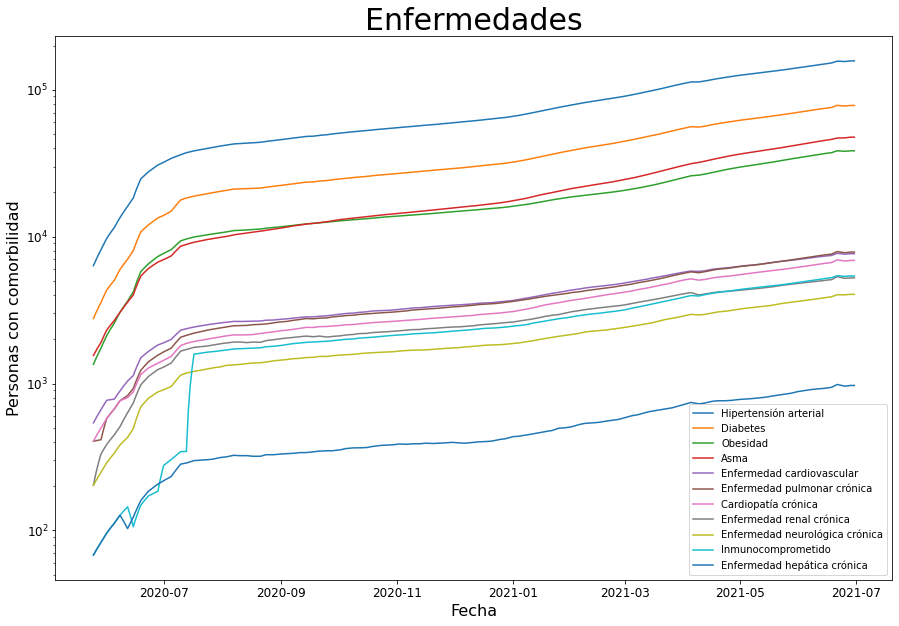

In [294]:
fig, ax3 = plt.subplots(1, 1)
ax3.plot(data.iloc[:,[4,5,6,7,8,9,10,11,12,13,14]])
ax3.legend(('Hipertensión arterial', 'Diabetes', 'Obesidad',
       'Asma', 'Enfermedad cardiovascular', 'Enfermedad pulmonar crónica',
       'Cardiopatía crónica', 'Enfermedad renal crónica',
       'Enfermedad neurológica crónica','Inmunocomprometido',
       'Enfermedad hepática crónica'))
plt.yscale('log')
plt.title("Enfermedades", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Personas con comorbilidad", fontsize=16)

Text(0, 0.5, 'Cantidad ventiladores')

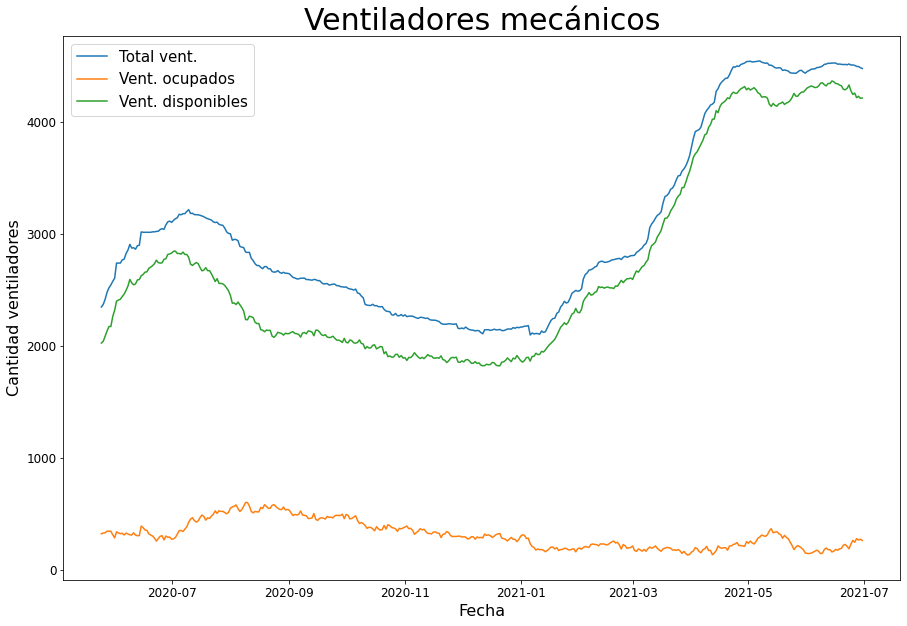

In [288]:
fig, ax4 = plt.subplots(1, 1)
ax4.plot(data.iloc[:,[19,20,21]])
ax4.legend(('Total vent.', 'Vent. ocupados',
       'Vent. disponibles'), fontsize=15)
plt.title("Ventiladores mecánicos", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Cantidad ventiladores", fontsize=16)

Text(0, 0.5, 'Casos activos')

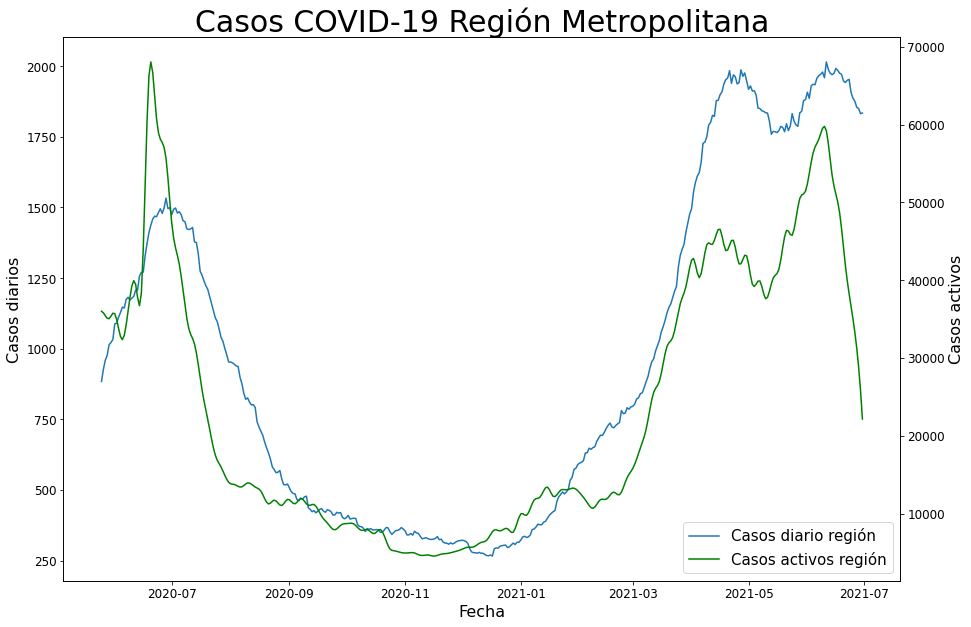

In [289]:
fig, ax5 = plt.subplots(1, 1)
diarios_plot = ax5.plot(data.iloc[:,23])
plt.title("Casos COVID-19 Región Metropolitana", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Casos diarios", fontsize=16)
ax6 = ax5.twinx()
activos_plot = ax6.plot(data.iloc[:,24], color="green")
plot = diarios_plot + activos_plot
ax5.legend(plot, ["Casos diario región", "Casos activos región"], fontsize=15, loc=4)
plt.ylabel("Casos activos", fontsize=16)

Text(0, 0.5, 'Cantidad ventiladores')

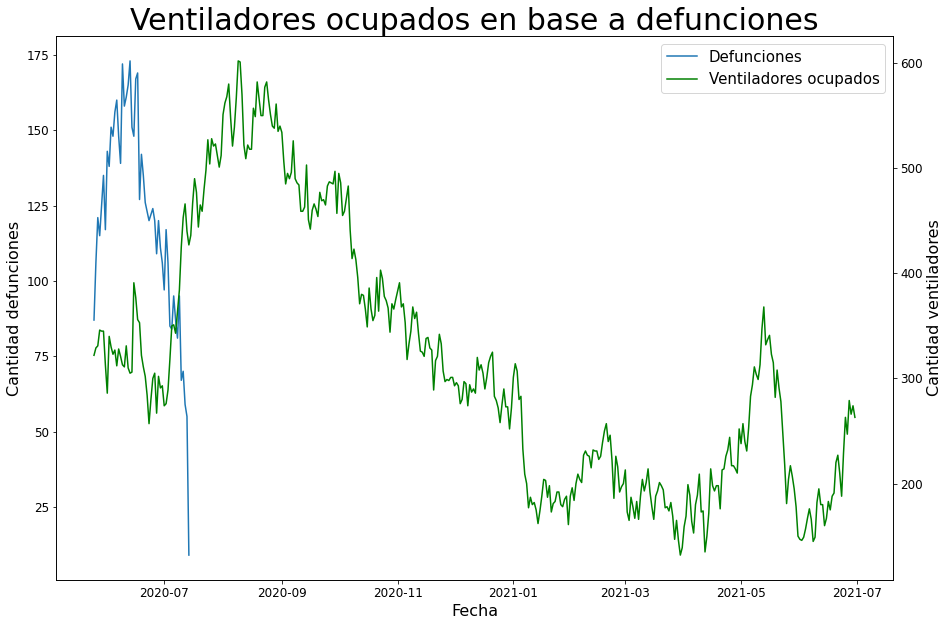

In [290]:
fig, ax7 = plt.subplots(1, 1)
defunciones_plot = ax7.plot(data.iloc[:,18])
#ax7.legend(('Defunciones', 'Vent. ocupados'), fontsize=15)
plt.title("Ventiladores ocupados en base a defunciones", fontsize=30)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Cantidad defunciones", fontsize=16)
ax8 = ax7.twinx()
ventiladores_plot = ax8.plot(data.iloc[:,20], color="green")
plot = defunciones_plot + ventiladores_plot
ax8.legend(plot, ["Defunciones", "Ventiladores ocupados"], fontsize=15)
plt.ylabel("Cantidad ventiladores", fontsize=16)

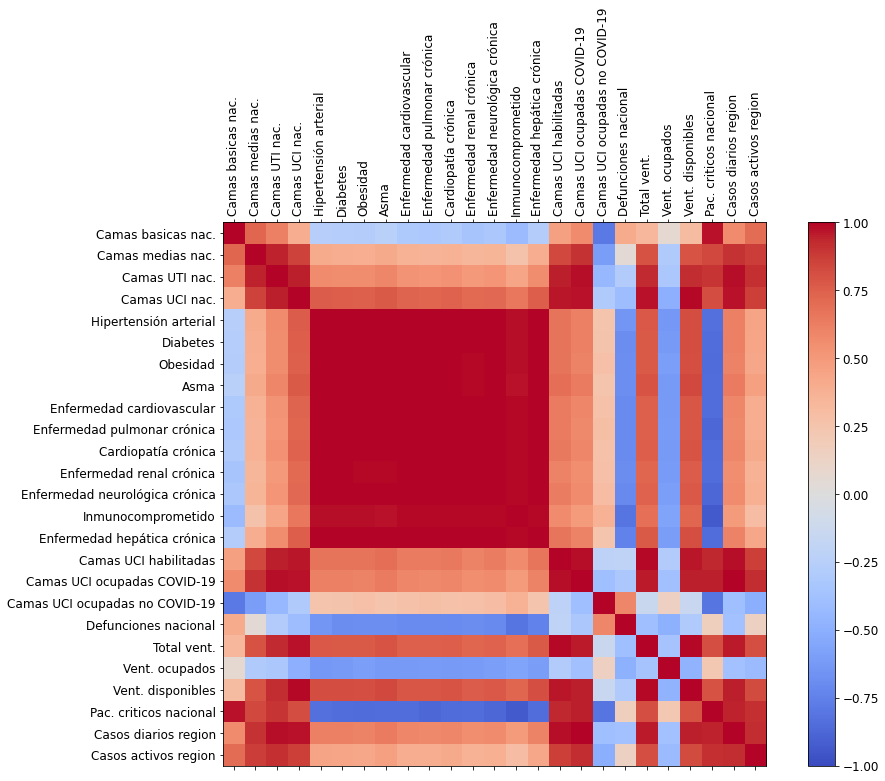

In [295]:
corr = data.corr(method="pearson")
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

In [292]:
data.columns

Index(['Camas basicas nac.', 'Camas medias nac.', 'Camas UTI nac.',
       'Camas UCI nac.', 'Hipertensión arterial', 'Diabetes', 'Obesidad',
       'Asma', 'Enfermedad cardiovascular', 'Enfermedad pulmonar crónica',
       'Cardiopatía crónica', 'Enfermedad renal crónica',
       'Enfermedad neurológica crónica', 'Inmunocomprometido',
       'Enfermedad hepática crónica', 'Camas UCI habilitadas',
       'Camas UCI ocupadas COVID-19', 'Camas UCI ocupadas no COVID-19',
       'Defunciones nacional', 'Total vent.', 'Vent. ocupados',
       'Vent. disponibles', 'Pac. criticos nacional', 'Casos diarios region',
       'Casos activos region'],
      dtype='object')